In [2]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o-mini")


In [3]:
from operator import add
from typing import TypedDict, List, Optional, Annotated

class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback:Optional[str]




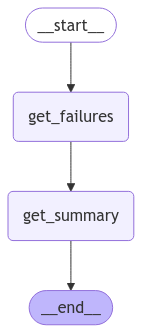

In [6]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END

class FailureAnalysisState(TypedDict):
    cleaned_logs : List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(StateGraph):
    fa_summary: str
    processed_logs: List[str]


def get_failures(state: FailureAnalysisState) -> FailureAnalysisState:
    "Get logs that contain a failure"
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade"  in log]
    return {"failures": failures}

def get_summary(state: FailureAnalysisState) -> FailureAnalysisOutputState:
    "GEnerates summary of failures"
    failures = state["failures"]
    # Add fxn: fa_summary = summarize_failures(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation"
    return {"fa_summary": fa_summary, "process_logs": [f"failure analysis on log {failure['id']}" for failure in failures]}

fa_builder = StateGraph(FailureAnalysisState, input=FailureAnalysisState, output=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("get_summary", get_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "get_summary")
fa_builder.add_edge("get_summary", END)
fa_graph = fa_builder.compile()

display(Image(fa_graph.get_graph().draw_mermaid_png()))


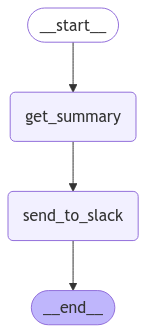

In [8]:
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qa_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(StateGraph):
    report: str
    processed_logs: List[str]

def get_summary(state: QuestionSummarizationState) -> QuestionSummarizationState:
   cleaned_logs = state["cleaned_logs"]
   #Add fxn summary = summarize("generate_summary")
   summary = "The user asked about the difference between Chroma and Langchain"
   return {"qa_summary": summary, "processed_logs": [f"question summarization on log {log['id']}" for log in cleaned_logs]}

def send_to_slack(state: QuestionSummarizationState) -> QuestionSummarizationOutputState:
    "Send the report to slack"
    qs_summary = state["qa_summary"]
    #add fxn: report = generate_report(qs_summary)
    report = "report to be sent to slack"
    return {"report": report}

qs_builder = StateGraph(QuestionSummarizationState, input=QuestionSummarizationState, output=QuestionSummarizationOutputState)
qs_builder.add_node("get_summary", get_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "get_summary")
qs_builder.add_edge("get_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)
qs_graph = qs_builder.compile()

display(Image(qs_graph.get_graph().draw_mermaid_png()))



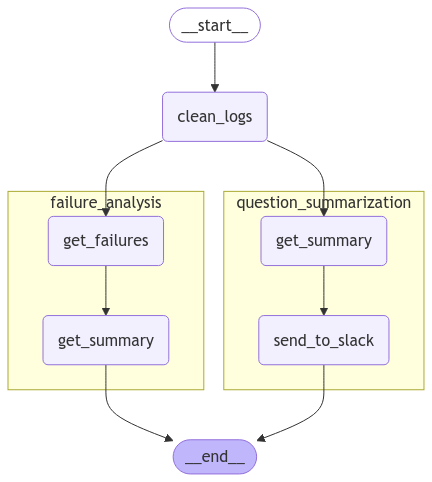

In [12]:
from typing import Annotated
from operator import add


class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str
    report: str
    processed_logs: Annotated[List[str], add]


def clean_logs(state: EntryGraphState) -> EntryGraphState:
    "Clean the logs"
    raw_logs = state["raw_logs"]
    cleaned_logs = raw_logs

    return {"cleaned_logs": cleaned_logs}


entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")

entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("clean_logs", "failure_analysis")

entry_builder.add_edge("question_summarization",END)
entry_builder.add_edge("failure_analysis", END)

entry_graph = entry_builder.compile()

display(Image(entry_graph.get_graph(xray=1).draw_mermaid_png()))




In [11]:
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]
entry_graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 